# Titanic - Machine Learning from Disaster


In [5]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from collections import Counter

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# validation
from sklearn.metrics import accuracy_score

In [2]:
encoder = LabelEncoder()
scaler = StandardScaler()

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
fake_submit = pd.read_csv("gender_submission.csv")
combine = [train_data, test_data]

In [7]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train_data,2,["Age","SibSp","Parch","Fare"])
train_data = train_data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

C:\Users\DELL\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Analyze

phân tích dựa trên những feature có sẵn, chưa tạo mới các feature khác

## Basic Analyze 

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
PassengerId    881 non-null int64
Survived       881 non-null int64
Pclass         881 non-null int64
Name           881 non-null object
Sex            881 non-null object
Age            711 non-null float64
SibSp          881 non-null int64
Parch          881 non-null int64
Ticket         881 non-null object
Fare           881 non-null float64
Cabin          201 non-null object
Embarked       879 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [10]:
train_data.describe(percentiles=[.1, .2, .3, .4, .5, .6, .7, .8, .9, .99])
# 1% la sibsp > 5
# 1% age > 65 ; 50% thuoc nhom [20,40]
# 38% survived -> 62% dead

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
10%,91.000000,0.000000,1.000000,14.000000,0.000000,0.000000,7.550000
20%,180.000000,0.000000,1.000000,19.000000,0.000000,0.000000,7.854200
30%,270.000000,0.000000,2.000000,22.000000,0.000000,0.000000,8.050000
40%,360.000000,0.000000,2.000000,25.000000,0.000000,0.000000,10.500000
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
60%,536.000000,0.000000,3.000000,32.000000,0.000000,0.000000,21.000000


In [11]:
train_data.describe(include=["O"])

,Name,Sex,Ticket,Cabin,Embarked
count,881,881,881,201,879
unique,881,2,680,147,3
top,"Williams-Lambert, Mr. Fletcher Fellows",male,347082,G6,S
freq,1,572,7,4,634


In [12]:
train_data.corr().sort_values(by="Survived")

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Pclass,-0.042702,-0.334097,1.000000,-0.374495,0.065031,0.016440,-0.555558
Age,0.034172,-0.076867,-0.374495,1.000000,-0.307129,-0.186457,0.110219
PassengerId,1.000000,-0.003089,-0.042702,0.034172,-0.072042,0.004052,0.031211
SibSp,-0.072042,0.003330,0.065031,-0.307129,1.000000,0.379281,0.110072
Parch,0.004052,0.092819,0.016440,-0.186457,0.379281,1.000000,0.183801
Fare,0.031211,0.264613,-0.555558,0.110219,0.110072,0.183801,1.000000
Survived,-0.003089,1.000000,-0.334097,-0.076867,0.003330,0.092819,0.264613


In [13]:
## Make assumtions

### Complete : Age, Embarked
### Convert: Sex, Ticket, Embarked
### Creating: Age Bands, Fare range, SibSp&Parch
### 

## Analyze by pivot point

In [14]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629108
1,2,0.472826
2,3,0.245868


In [15]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.747573
1,male,0.190559


In [16]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339117


In [17]:
train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


In [18]:
train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


## Visualize Analyze

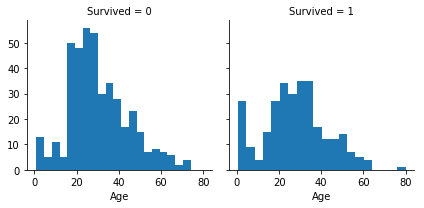

In [19]:
## Age vs Survived

g = sns.FacetGrid(train_data, col='Survived')
g.map(plt.hist, 'Age', bins=20)

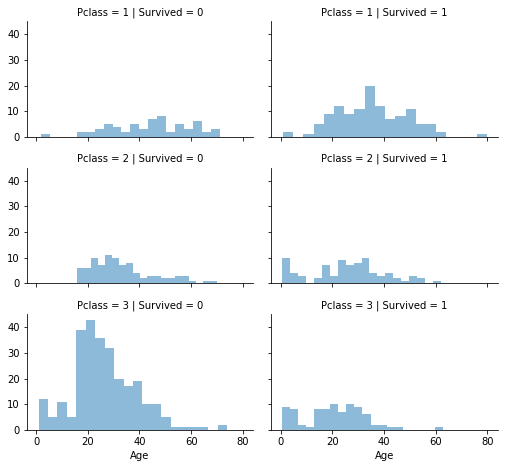

In [20]:
## Age vs Survived | Pclass

# grid = sns.FacetGrid(train_data, col='Pclass', hue='Survived')
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

C:\Users\DELL\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\DELL\Anaconda3\lib\site-packages\seaborn\axisgrid.py:720: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\DELL\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


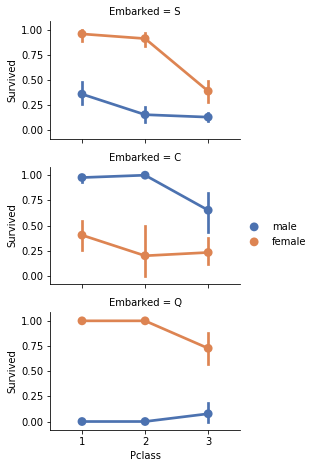

In [21]:
## Pclass vs Sex vs Survived | Embarked
grid = sns.FacetGrid(train_data, row='Embarked', height=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

C:\Users\DELL\Anaconda3\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


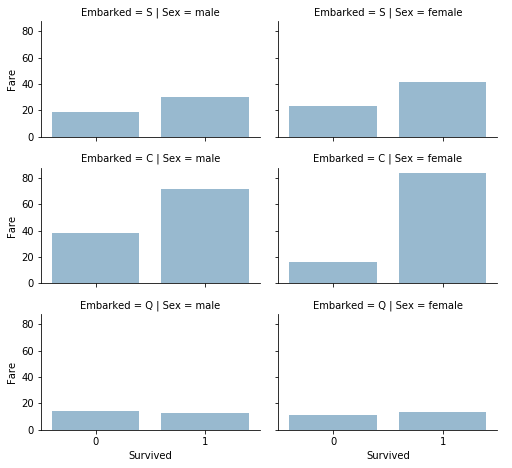

In [22]:
## Fare vs Survived | Embarked vs Sex
grid = sns.FacetGrid(train_data, row='Embarked', col='Sex', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Survived', 'Fare', alpha=.5, ci=None)
grid.add_legend()

# Wrangle data

In [23]:
train_data = train_data.drop(["Cabin", "PassengerId", "Name"], axis = 1)
test_data = test_data.drop(["Cabin", "Name"], axis = 1)
combine = [train_data, test_data]

In [24]:
for dataset in combine:
    dataset["Sex"] = encoder.fit_transform(dataset["Sex"]) 

In [25]:
freq_port = train_data["Embarked"].dropna().mode()
for dataset in combine:
    dataset["Embarked"] = dataset["Embarked"].fillna(freq_port[0])
    dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].mean())

In [26]:
for dataset in combine:
    dataset["Embarked"] = encoder.fit_transform(dataset["Embarked"]) 

In [27]:
for dataset in combine:
    dataset["Family Size"] = dataset["SibSp"] + dataset["Parch"] + 1
    
for dataset in combine:
    dataset["Alone"] = 0
    dataset.loc[dataset["Family Size"] == 1, "Alone"] = 1

In [28]:
train_data = train_data.drop(["Family Size", "SibSp", "Parch"], axis = 1)
test_data = test_data.drop(["Family Size", "SibSp", "Parch"], axis = 1)
combine = [train_data, test_data]

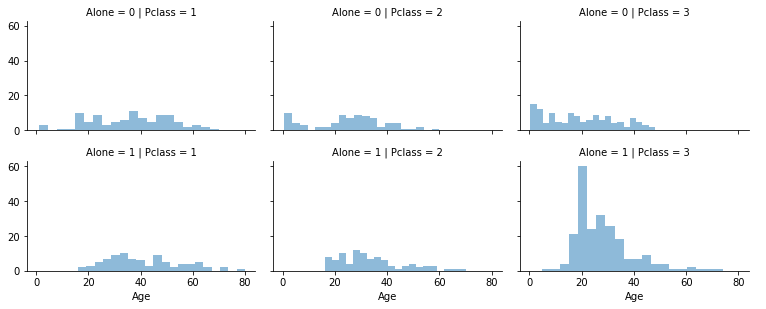

In [29]:
grid = sns.FacetGrid(train_data, col='Pclass', row='Alone', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [30]:
age_guess = np.zeros((train_data["Alone"].unique().size, train_data["Pclass"].unique().size))

In [31]:
age_guess.shape

(2, 3)

In [32]:
for dataset in combine:
    for i in range(age_guess.shape[0]):
        for j in range(age_guess.shape[1]):
            guess_df = dataset.loc[(dataset["Alone"] == i) & (dataset["Pclass"] == j + 1), "Age"].dropna()
            guess = guess_df.mean()
            age_guess[i,j] = guess
    for i in range(age_guess.shape[0]):
        for j in range(age_guess.shape[1]):
            dataset.loc[(dataset["Age"].isnull()) & (dataset["Alone"] == i) & (dataset["Pclass"] == j + 1), "Age"] = age_guess[i,j]
    dataset["Age"] = np.round(dataset["Age"])

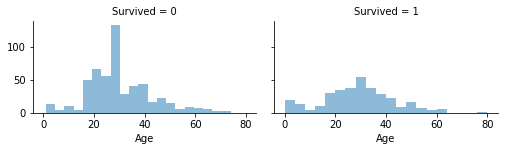

In [33]:
grid = sns.FacetGrid(train_data, col='Survived', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

In [34]:
train_data["AgeBand"] = pd.cut(train_data["Age"], 5)
train_data[["AgeBand", "Survived"]].groupby("AgeBand", as_index=False).mean().sort_values(by="AgeBand")

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.339662
2,"(32.0, 48.0]",0.409692
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [35]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']

In [36]:
train_data = train_data.drop("Ticket", axis=1)
test_data = test_data.drop("Ticket", axis=1)
combine = [train_data, test_data]

In [37]:
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
train_data[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.896]",0.197309
1,"(7.896, 14.454]",0.303571
2,"(14.454, 30.5]",0.456221
3,"(30.5, 512.329]",0.594470


In [38]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3

In [39]:
train_data = train_data.drop(["AgeBand", "FareBand"], axis = 1)

# Model

In [40]:
X = train_data.drop("Survived", axis=1)
y = train_data["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_data.drop("PassengerId", axis=1)

In [48]:
logreg = LogisticRegression(solver="lbfgs")
logreg.fit(X_train, y_train)
log_pred = logreg.predict(X_val)
print("Accuracy score:", accuracy_score(log_pred, y_val))
print("Train Accuracy: ", accuracy_score(logreg.predict(X_train), y_train))

Accuracy score: 0.7740112994350282
Train Accuracy:  0.7840909090909091


In [55]:
svc = SVC(kernel="rbf", C=0.9, gamma=0.2)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_val)
print("Val Accuracy: ", accuracy_score(svc_pred, y_val))
print("Train Accuracy: ", accuracy_score(svc.predict(X_train), y_train))

Val Accuracy:  0.807909604519774
Train Accuracy:  0.8267045454545454


In [59]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_val)
print("Val Accuracy: ", accuracy_score(knn_pred, y_val))
print("Train Accuracy: ", accuracy_score(knn.predict(X_train), y_train))

Val Accuracy:  0.8022598870056498
Train Accuracy:  0.8423295454545454


In [61]:
tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_val)
print("Val Accuracy: ", accuracy_score(tree_pred, y_val))
print("Train Accuracy: ", accuracy_score(tree.predict(X_train), y_train))

Val Accuracy:  0.7909604519774012
Train Accuracy:  0.8139204545454546


In [62]:
forest = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5)
forest.fit(X_train, y_train)
forest_pred = forest.predict(X_val)
print("Val Accuracy: ", accuracy_score(forest_pred, y_val))
print("Train Accuracy: ", accuracy_score(forest.predict(X_train), y_train))

Val Accuracy:  0.8192090395480226
Train Accuracy:  0.8338068181818182


# Submit

In [63]:
y_test = forest.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_data["PassengerId"],
        "Survived": y_test
})
submission.to_csv('submission.csv', index=False)